In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
import time
from sklearn.metrics import explained_variance_score

In [2]:
class AP_GRU(nn.Module):
    def __init__(self, H_no, device):
        super().__init__()
        
        self.H_no = H_no
        self.device = device
        
        self.rnn = nn.GRU(2, H_no, batch_first=True)
        self.linear = nn.Linear(H_no, 1)
        
    def forward(self, V, D):
        #V, D is shape (batch, 50000)
        
        VD = torch.zeros(V.shape[0], V.shape[1], 2).to(self.device)
        VD[:,:,0] = VD[:,:,0] + V
        VD[:,:,1] = VD[:,:,1] + D
        
        rnn_out, _ = self.rnn(VD) #(batch,50000,H)
        rnn_out = rnn_out.reshape(-1,self.H_no)
        lin_out = self.linear(rnn_out) #(batch*50000,1)
        lin_out = lin_out.reshape(V.shape[0], V.shape[1])
        
        return lin_out



In [3]:
batch_size = 20
batch_length = 50000
H_no = 20
device = torch.device("cuda")

epoch_no = 200
iter_no = epoch_no * 980 // batch_size

#V = np.load("/media/hdd01/sklee/CA1_clust4-60/data/vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy").reshape(-1,50001)[:,:50000].flatten()
V = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/whole_pred/V_whole_pred.npy").flatten()

#D = np.zeros((V.shape[0]))
#D[:-1] = np.diff(V)
D = V.copy()
#D_train = np.load("/media/hdd01/sklee/CA1_clust4-60/hand/gru_s10_h20_extra_output.npz")["test"]
#D_test = np.load("/media/hdd01/sklee/CA1_clust4-60/hand/gru_s10_h20_output.npz")["test"]
#D_train = torch.from_numpy(D_train).float()
#D_test = torch.from_numpy(D_test).float().to(device)

D = D.reshape(-1,batch_length)
V = V.reshape(-1,batch_length)
S = np.load("/media/hdd01/sklee/CA1_clust4-60_AP/data/V_diff_stimseed1.npy").reshape(-1,batch_length)

V = torch.from_numpy(V)
D = torch.from_numpy(D)
S = torch.from_numpy(S)


In [4]:
V_train = V[:980].float()
V_test = V[980:].float().to(device)
D_train = D[:980].float()
D_test = D[980:].float().to(device)
S_train = S[:980].float()
S_test = S[980:].float() .to(device)

train_idx = np.empty((epoch_no, 980//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0,980,batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)


In [5]:
model = AP_GRU(H_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

bce_criterion = nn.BCELoss(reduction="mean")

1461


In [6]:
score_list = []

part_time_idx = torch.arange(12000,32000)

for i in tnrange(iter_no):
    s = time.time()
    model.train()
    optimizer.zero_grad()
    
    batch_idx_start = train_idx[i]
    batch_idx = torch.arange(batch_idx_start, batch_idx_start+5).long()
    batch_S = S_train[batch_idx].to(device)[:,part_time_idx]
    batch_V = V_train[batch_idx].to(device)[:,part_time_idx]
    batch_D = D_train[batch_idx].to(device)[:,part_time_idx]
    
    S_out = model(batch_V, batch_D)
    loss = torch.mean((S_out - batch_S)**2)
    loss.backward()
    optimizer.step()
    
    step_time = time.time() - s
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_S_out = model(V_test[:,part_time_idx], D_test[:,part_time_idx])
        test_loss = explained_variance_score(S_test[:,part_time_idx].cpu().detach().numpy().flatten(), test_S_out.cpu().detach().numpy().flatten())
        
        score_list.append(test_loss)
        print(i, test_loss, step_time)

<ipython-input-6-c0b0dca94fca>:5: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/9800 [00:00<?, ?it/s]

0 0.006570994853973389 0.8449969291687012
49 0.024276256561279297 1.0801820755004883
99 0.03787428140640259 1.0770502090454102
149 0.02297961711883545 1.083847999572754
199 0.03146868944168091 1.0849974155426025
249 0.041662752628326416 1.0807979106903076
299 0.0637938380241394 1.0781121253967285
349 0.09168076515197754 1.0966925621032715
399 0.09211939573287964 1.08292818069458
449 0.019584357738494873 1.0649681091308594
499 0.04745298624038696 1.08180832862854
549 0.08243304491043091 1.074866771697998
599 0.08576762676239014 1.0801458358764648
649 0.10852557420730591 1.0935051441192627
699 0.11431294679641724 1.0876235961914062
749 0.12103933095932007 1.0873475074768066
799 0.11942499876022339 1.0680756568908691
849 0.11320286989212036 1.0975289344787598
899 0.12587374448776245 1.0792200565338135
949 0.12618470191955566 1.068650722503662
999 0.040556371212005615 1.0841443538665771
1049 0.1109166145324707 1.097627878189087
1099 0.13054144382476807 1.0996780395507812
1149 0.13830691576

9499 0.18346869945526123 1.0848948955535889
9549 0.191308856010437 1.0801143646240234
9599 0.1983644962310791 1.0809051990509033
9649 0.19114047288894653 1.064746618270874
9699 0.19758480787277222 1.0704188346862793
9749 0.18178850412368774 1.0804715156555176
9799 0.19232076406478882 0.5736570358276367


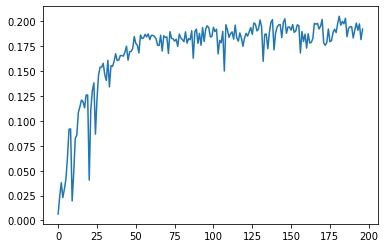

In [7]:
plt.plot(np.asarray(score_list))

(-1.0, 10.0)

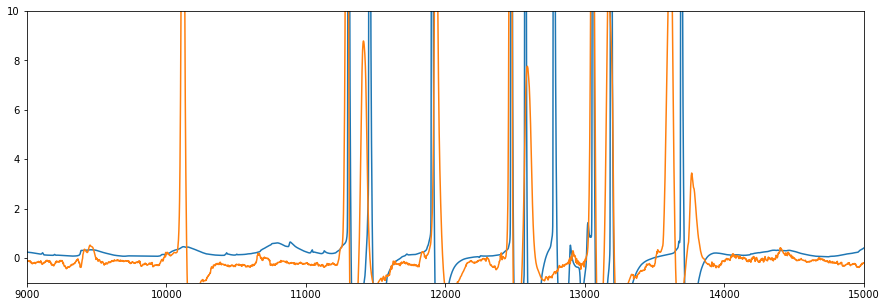

In [8]:
plt.figure(figsize = (15,5))
plt.plot(S_test[0].cpu().detach().numpy()[part_time_idx])
plt.plot(test_S_out[1].cpu().detach().numpy())
plt.xlim(9000,15000)
plt.ylim(-1,10)

In [9]:
#torch.save(model.state_dict(), "/media/hdd01/sklee/CA1_clust4-60_AP/whole_pred/gru_h20.pt")
#np.save("/media/hdd01/sklee/CA1_clust4-60_AP/whole_pred/gru_h20_test.npy", test_S_out.cpu().detach().numpy())